In [ ]:
!pip install --upgrade ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling n

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/bootstrapping_dataset.zip'
extract_path = '/content/bootstrapping_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    zip_ref.extractall(extract_path)

# ✅ Your images are now in:
bootstrapping_img_path = '/content/bootstrapping_data/train/images'

Mounted at /content/drive



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1067 /content/bootstrapping_data/train/images/keyframe_00195_boat_jpg.rf.8889eb577a246f283d828d0f4f918682.jpg: 640x640 2 cars, 298.2ms
image 2/1067 /content/bootstrapping_data/train/images/keyframe_00233_airplane_jpg.rf.7dc903697a673a8e90b7c1a37181a682.jpg: 640x640 1 car, 298.1ms
image 3/1067 /content/bootstrapping_data/train/images/keyframe_00250_boat_jpg.rf.9255d1de5e54887ff7ac20dbfc07b345.jpg: 640x640 1 car, 316.2ms
image 4/1067 /content/boo

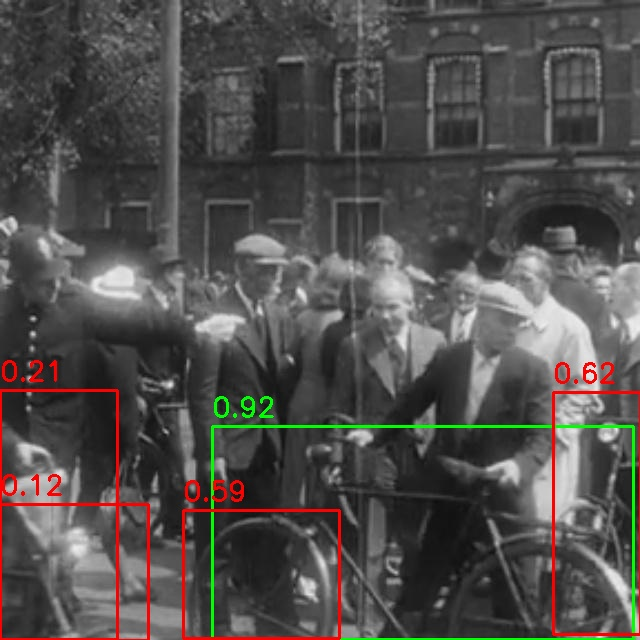

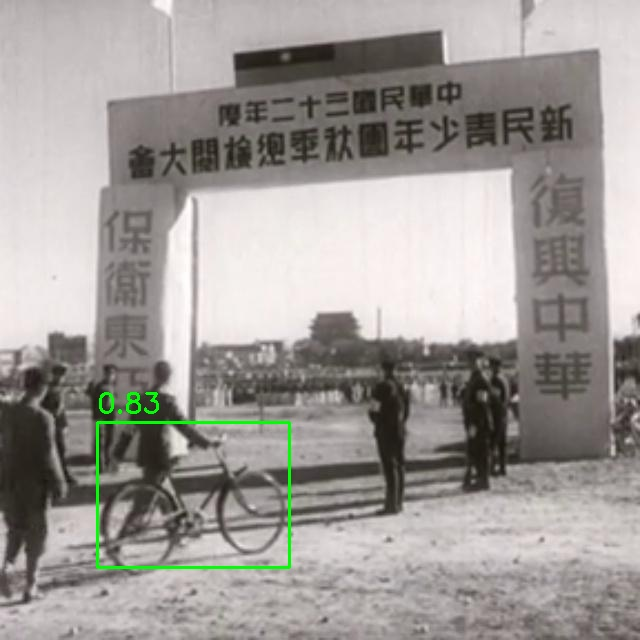

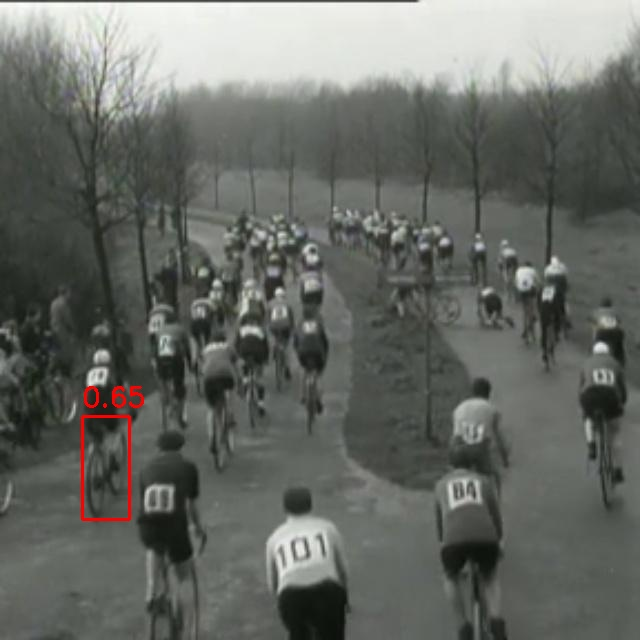

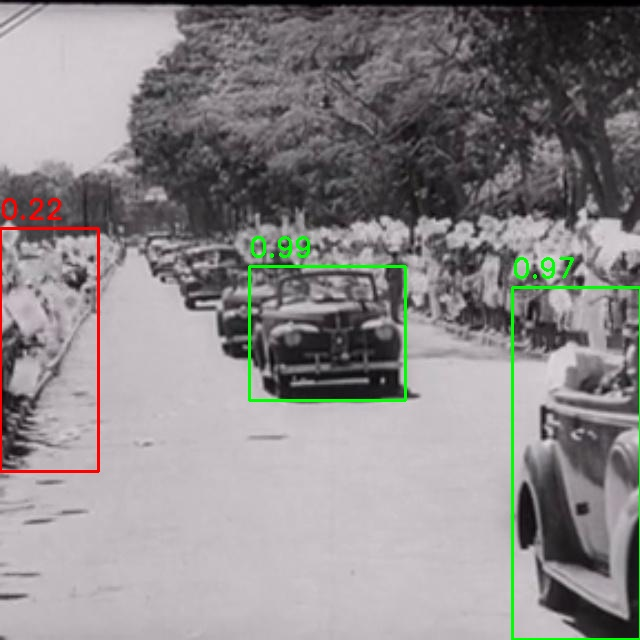

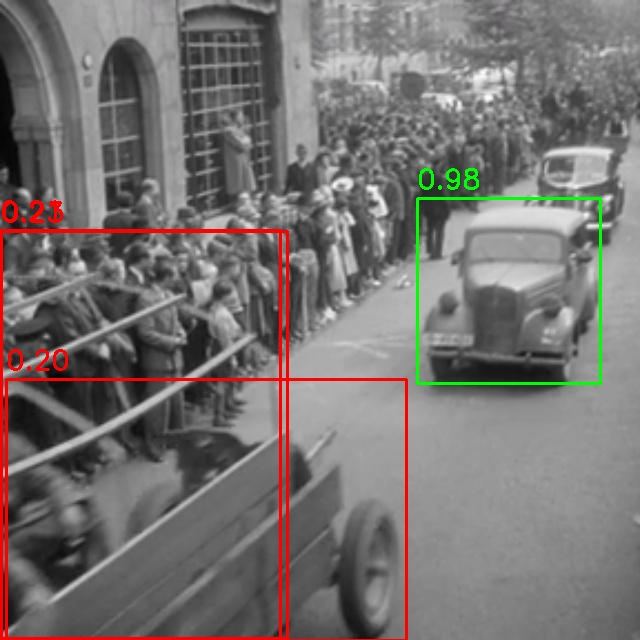

Verification-ready dataset created and zipped as manual_verification.zip


In [ ]:
from ultralytics import YOLO
import os
import shutil
from pathlib import Path
from IPython.display import Image, display
import cv2
import zipfile

# 1. Initial Prediction
model_path = '/content/drive/MyDrive/no_leakage_dataset2/model_b.pt'
model = YOLO(model_path)

results = model.predict(
    source=bootstrapping_img_path,
    save_txt=True,
    save_conf=True,
    project='runs/bootstrapping_preds',
    name='model_b_preds',
    conf=0.1,
    iou=0.5,
    device='cpu'
)

# 2. Create High-Confidence Dataset
def create_high_conf_dataset(pred_labels_dir, images_dir, output_dir, min_conf=0.7):
    """
    Create dataset of high-confidence predictions for manual review
    Includes ALL bounding boxes in labels for images that have at least one high-confidence prediction
    """
    os.makedirs(f"{output_dir}/images", exist_ok=True)
    os.makedirs(f"{output_dir}/labels", exist_ok=True)

    count_high_conf = 0
    count_images = 0

    for pred_file in Path(pred_labels_dir).glob('*.txt'):
        # Read all predictions
        with open(pred_file, 'r') as f:
            all_preds = [line.strip().split() for line in f]
            high_conf_preds = [p for p in all_preds if float(p[5]) >= min_conf]

        if high_conf_preds:
            count_high_conf += len(high_conf_preds)
            count_images += 1

            # Copy image
            img_name = pred_file.stem + '.jpg'
            shutil.copy2(f"{images_dir}/{img_name}", f"{output_dir}/images/{img_name}")

            # Save ALL predictions (not just high confidence) for the image
            with open(f"{output_dir}/labels/{pred_file.name}", 'w') as f:
                f.write('\n'.join([' '.join(p) for p in all_preds]))

    print(f"Created dataset with {count_images} images containing {count_high_conf} high-confidence (≥{min_conf}) predictions")
    print(f"All bounding boxes (including low-confidence) are included in the labels for these images")

# 3. Create the dataset with confidence threshold
create_high_conf_dataset(
    pred_labels_dir="runs/bootstrapping_preds/model_b_preds/labels",
    images_dir=bootstrapping_img_path,
    output_dir="high_conf_predictions",
    min_conf=0.7
)

# 4. Preview Helper
def preview_predictions(dataset_dir, num_samples=5):
    """Visual inspection of predictions"""
    preview_dir = f"{dataset_dir}/images"
    image_paths = list(Path(preview_dir).glob('*.jpg'))[:num_samples]

    for img_path in image_paths:
        img = cv2.imread(str(img_path))
        label_path = f"{dataset_dir}/labels/{img_path.stem}.txt"

        if Path(label_path).exists():
            with open(label_path) as f:
                for line in f.readlines():
                    _, x, y, w, h, conf = map(float, line.split())
                    # Convert from normalized coords
                    img_h, img_w = img.shape[:2]
                    x_center = x * img_w
                    y_center = y * img_h
                    box_w = w * img_w
                    box_h = h * img_h
                    x1 = int(x_center - box_w/2)
                    y1 = int(y_center - box_h/2)
                    x2 = int(x_center + box_w/2)
                    y2 = int(y_center + box_h/2)

                    # Color code based on confidence
                    color = (0, 255, 0) if conf >= 0.7 else (0, 0, 255)  # Green for high, red for low
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(img, f"{conf:.2f}", (x1, y1-10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        cv2.imwrite("temp.jpg", img)
        display(Image(filename="temp.jpg"))
        os.remove("temp.jpg")

# 5. Preview some examples
print("Previewing predictions (green=high confidence, red=low confidence):")
preview_predictions("high_conf_predictions")

# 6. Create verification-ready structure and zip it
def prepare_and_zip_output(dataset_dir, output_zip_name):
    """Organize predictions and create zip file"""
    # First create verification structure
    verification_dir = "manual_verification"
    os.makedirs(verification_dir, exist_ok=True)

    # Create CSV with all predictions for tracking
    import csv
    with open(f"{verification_dir}/verification_log.csv", 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['image_name', 'label_file', 'num_predictions', 'num_high_conf', 'status'])

        for label_file in Path(f"{dataset_dir}/labels").glob('*.txt'):
            with open(label_file, 'r') as f:
                all_preds = [line.split() for line in f.readlines()]
                high_conf = [p for p in all_preds if float(p[5]) >= 0.7]
            img_name = label_file.stem + '.jpg'
            writer.writerow([img_name, label_file.name, len(all_preds), len(high_conf), 'unverified'])

    # Copy images and labels to verification folder
    shutil.copytree(f"{dataset_dir}/images", f"{verification_dir}/images", dirs_exist_ok=True)
    shutil.copytree(f"{dataset_dir}/labels", f"{verification_dir}/labels", dirs_exist_ok=True)

    # Create zip file
    with zipfile.ZipFile(output_zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(verification_dir):
            for file in files:
                zipf.write(os.path.join(root, file),
                          os.path.relpath(os.path.join(root, file),
                                        os.path.join(verification_dir, '..')))

    print(f"Verification-ready dataset created and zipped as {output_zip_name}")

# 7. Create verification structure and zip it
prepare_and_zip_output("high_conf_predictions", "manual_verification.zip")

In [ ]:
import os
import shutil
from pathlib import Path

# Set your paths
BOOTSTRAPPING_IMG_DIR = "/content/bootstrapping_data/train/images"
BOOTSTRAPPING_LABEL_DIR = "/content/bootstrapping_data/train/labels"
MANUAL_VERIFICATION_IMG_DIR = "/content/manual_verification/images"
MANUAL_VERIFICATION_LABEL_DIR = "/content/manual_verification/labels"

def clean_bootstrapping_data():
    """
    Removes images and labels from bootstrapping folders that exist in manual verification
    Returns count of removed items and remaining images
    """
    # Get list of labeled images (just the filenames without extension)
    labeled_images = {f.stem for f in Path(MANUAL_VERIFICATION_IMG_DIR).glob("*.jpg")}

    removed_images = 0
    removed_labels = 0
    remaining_files = []

    # Process bootstrapping images
    for img_path in Path(BOOTSTRAPPING_IMG_DIR).glob("*.jpg"):
        if img_path.stem in labeled_images:
            # Remove the image
            os.remove(str(img_path))
            removed_images += 1

            # Remove corresponding label if it exists
            label_path = Path(BOOTSTRAPPING_LABEL_DIR) / f"{img_path.stem}.txt"
            if label_path.exists():
                os.remove(str(label_path))
                removed_labels += 1
        else:
            remaining_files.append(img_path.name)

    print(f"✅ Removed {removed_images} images and {removed_labels} labels")
    print(f"📁 {len(remaining_files)} images remaining in bootstrapping data")

    # Show some remaining files as verification
    if remaining_files:
        print("\n🔍 Sample of remaining images:")
        for f in remaining_files[:3]:
            print(f" - {f}")
    else:
        print("\n⚠️ No images remaining - upload new data for next iteration")

    return removed_images, len(remaining_files)

# Create labels directory if it doesn't exist
os.makedirs(BOOTSTRAPPING_LABEL_DIR, exist_ok=True)

# Run the cleanup
removed, remaining = clean_bootstrapping_data()

# Create a zip backup of remaining data
if remaining > 0:
    !zip -r /content/cleaned_bootstrapping_data.zip {BOOTSTRAPPING_IMG_DIR} {BOOTSTRAPPING_LABEL_DIR}
    print("\n📦 Created backup zip at /content/cleaned_bootstrapping_data.zip")

✅ Removed 576 images and 576 labels
📁 491 images remaining in bootstrapping data

🔍 Sample of remaining images:
 - keyframe_18287_bicycle_jpg.rf.3d9991393157624cdada4a71b2758a91.jpg
 - keyframe_10502_car_jpg.rf.b40090da36c1f02ecb213b7812a4a0f7.jpg
 - keyframe_20719_bicycle_jpg.rf.aeb98502228a53e561562c5a16cde504.jpg
  adding: content/bootstrapping_data/train/images/ (stored 0%)
  adding: content/bootstrapping_data/train/images/keyframe_18287_bicycle_jpg.rf.3d9991393157624cdada4a71b2758a91.jpg (deflated 2%)
  adding: content/bootstrapping_data/train/images/keyframe_10502_car_jpg.rf.b40090da36c1f02ecb213b7812a4a0f7.jpg (deflated 1%)
  adding: content/bootstrapping_data/train/images/keyframe_20719_bicycle_jpg.rf.aeb98502228a53e561562c5a16cde504.jpg (deflated 0%)
  adding: content/bootstrapping_data/train/images/keyframe_13793_bicycle_jpg.rf.505391bc4baf5a92086ed20a21398485.jpg (deflated 1%)
  adding: content/bootstrapping_data/train/images/keyframe_24234_car_jpg.rf.27ef4140430845f66685beb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')